In [30]:
import json
from jupyter_jsmol import JsmolView
from ipywidgets import Layout, widgets, interact
from IPython.display import display, Image
import os
from tqdm import tqdm
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure import bandstructure as bs
import matplotlib.pyplot as plt
import numpy as np


mpr = MPRester(api_key="XLgeaWrG6lipMAIH")

data = []
entrie = mpr.query("mp-924128", ["material_id", "cif"])
data.extend(entrie)

# Télécharger le .cif

In [31]:
if not os.path.exists('lmapr1492_cifs'):
    os.mkdir('lmapr1492_cifs')

for d in tqdm(data):
    with open("lmapr1492_cifs/{}.cif".format(d["material_id"]), 'w') as f:
        f.write(d["cif"])

100%|██████████| 1/1 [00:00<00:00, 117.85it/s]


# Déterminer la bande interdite

{'direct': False, 'energy': 0.3868999999999998, 'transition': '\\Gamma-X'}

Bande directe ? :  False
Energie :  0.3868999999999998 eV
Transition :  \Gamma-X


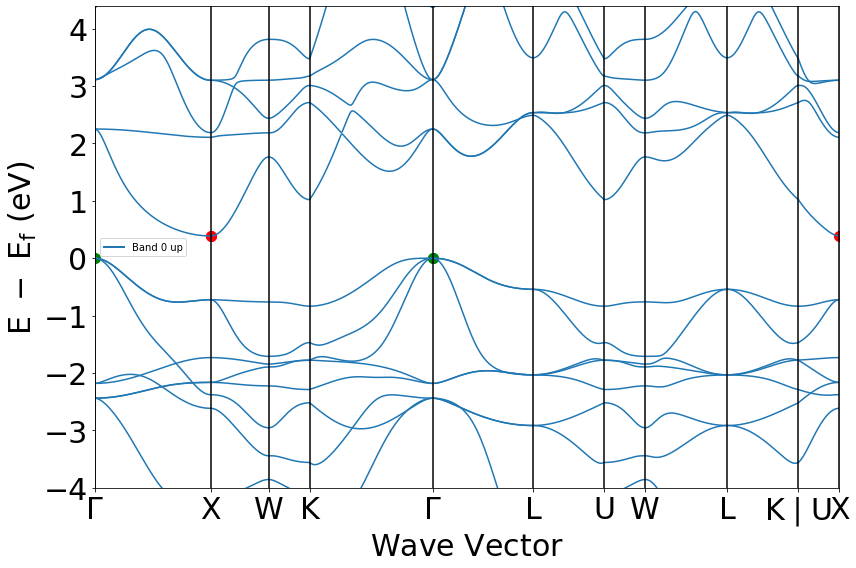

In [32]:
structure = mpr.get_structure_by_material_id("mp-924128")
bands     = mpr.get_bandstructure_by_material_id("mp-924128") 

bplot = plotter.BSPlotter(bands)
bplot.get_plot(vbm_cbm_marker = True)

bandgap = bands.get_band_gap()
print(bandgap)
print("")
print("Bande directe ? : ", bandgap['direct'])
print("Energie : ", bandgap['energy'], 'eV')
print("Transition : ", bandgap['transition'])

# Trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion

In [33]:
data = bplot.bs_plot_data()['distances']
energy = bplot.bs_plot_data()['energy']

vbm = bands.get_vbm()
print("Index of the first Valence Band :",vbm['band_index'])

cbm = bands.get_cbm()
print("Index of the last Conduction Band :",cbm['band_index'])

Index of the first Valence Band : defaultdict(<class 'list'>, {<Spin.up: 1>: [17, 18, 19]})
Index of the last Conduction Band : defaultdict(<class 'list'>, {<Spin.up: 1>: [20]})


<string>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



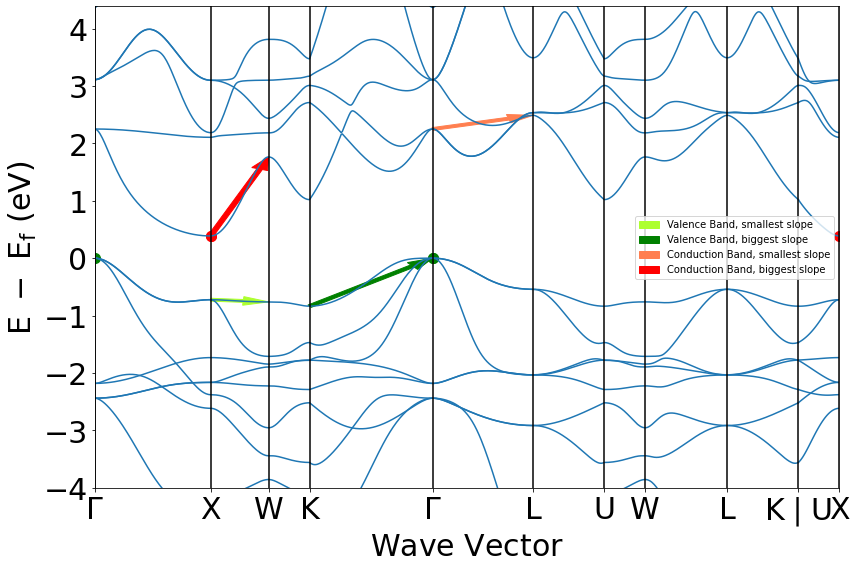

In [34]:
# pentes
slope_val  = np.empty_like(data, dtype=object)
slope_cond = np.empty_like(data, dtype=object)

for i in range(len(data)):
    slope_val[i] = abs((energy['1'][i][19][0] - energy['1'][i][19][-1])/(data[i][-1]-data[i][0]))
    slope_cond[i] = abs((energy['1'][i][20][0] - energy['1'][i][20][-1])/(data[i][-1]-data[i][0]))
    
# maximas et minimas
max_val = np.argmax(slope_val)
min_val = np.argmin(slope_val)
max_cond = np.argmax(slope_cond)
min_cond = np.argmin(slope_cond)

bplot.get_plot(vbm_cbm_marker=True)
#Pour la plus petite pente de la bande de valence -> greenyellow
plt.arrow(data[min_val][0],energy['1'][min_val][19][0],data[min_val][-1]-data[min_val][0],energy['1'][min_val][19][-1]-energy['1'][min_val][19][0],width = 0.05,length_includes_head=True,color='greenyellow', label ="Valence Band, smallest slope") 
#Pour la plus grande pente de la bande de valence -> green
plt.arrow(data[max_val][0],energy['1'][max_val][19][0],data[max_val][-1]-data[max_val][0],energy['1'][max_val][19][-1]-energy['1'][max_val][19][0],width = 0.05,length_includes_head=True,color='green', label ="Valence Band, biggest slope") 
#Pour la plus petite pente de la bande de conduction -> coral
plt.arrow(data[min_cond][0],energy['1'][min_cond][20][0],data[min_cond][-1]-data[min_cond][0],energy['1'][min_cond][20][-1]-energy['1'][min_cond][20][0],width = 0.05,length_includes_head=True,color='coral', label ="Conduction Band, smallest slope")
#Pour la plus grande pente de la bande de conduction -> red
plt.arrow(data[max_cond][0],energy['1'][max_cond][20][0],data[max_cond][-1]-data[max_cond][0],energy['1'][max_cond][20][-1]-energy['1'][max_cond][20][0],width = 0.05,length_includes_head=True,color='red', label ="Conduction Band, biggest slope")  
plt.legend()
plt.show()

# Calculer la masse effective

Comme on suppose une dispersion parabolique, l'équation de la masse effective $m^*$ peut s'écrire :

\begin{equation}
    m^* = \frac{\hbar^2}{\frac{d^2E}{dk^2}}
\end{equation}
avec $\hbar$ la contante réduite de Planck.

Pour des états proches des maxima et minima de bandes, cette équation s'approxime par l'équation suivante :

\begin{equation}
    E(k)-E_0=\pm \frac{\hbar^2}{2m^*}(k_x^2+k_y^2+k_z^2) \longrightarrow m^* = \pm \frac{\hbar^2}{2\left(E(k)-E_0\right)}(k_x^2+k_y^2+k_z^2)
\end{equation}

In [35]:
h_bar = 6.582119570 * 1e-16

kpoint = vbm.get('kpoint').frac_coords

k = np.linalg.norm(kpoint)

print('Norme k :', k) 

Norme k : 0.0


La norme étant nulle, il faut profiter de la périodicité. En effet, $E_{n,k}=E_{n,k+\Omega}$ avec $n$ le numéro de la bande et $\mathbf{\Omega}=l'\Omega+m'\Omega+n'\Omega$ un vecteur du réseau réciproque. La norme de $\Omega$ nous est donnée par $\Omega=p\frac{2\pi}{a}$ avec $a$ la norme du vecteur de base du réseau direct et $p$ un entier. 

In [36]:
#Valeur de la norme de a
a = 4.32362562676858

#Calcul de la norme de Omega
Omega = 2*np.pi/a

#Récupération de l'énergie associée au VBM
E = vbm['energy']

#Calcul de la masse effective
m_e = h_bar**2*Omega**2/(2*E)
print('Masse effective du sommet de la dernière bande de Valence :' , m_e, ' kg')

Masse effective du sommet de la dernière bande de Valence : 6.546733235566465e-32  kg


In [37]:
kpoint = cbm.get('kpoint').frac_coords

k = np.linalg.norm(kpoint)

print('Norme k :', k) 

Norme k : 0.7071067811865476


In [38]:
E = cbm['energy']

#Calcul de la masse effective
m_e = h_bar**2*k**2/(2*E)
print('Masse effective du sommet de la dernière bande de Valence :' , m_e, ' kg')

Masse effective du sommet de la dernière bande de Valence : 1.4686800152472978e-32  kg
